# Generative adversarial networks

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.


---

In [16]:
import numpy as np
import theano
import theano.tensor as T

import lasagne
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

Generates noise of M points (x,y)

In [2]:
mu = 0
sigma = 1
M = 800
a= -150
b= 0

In [3]:
def sample_noise(M):
    z = (b - a) * np.random.random(2 * M) +a
    return z.reshape(M,2)

In [4]:
sample_noise(15)

array([[ -29.20231301,  -61.26506992],
       [-147.52570209, -139.60807273],
       [-136.78769446, -134.7894915 ],
       [ -48.99190161,  -91.20277781],
       [ -88.14727367,  -17.74195673],
       [-102.8170394 , -125.61230932],
       [-133.04033935, -138.03586803],
       [-110.61608465,  -73.06740146],
       [ -48.92179593,  -91.18896764],
       [-119.14086595, -101.35285522],
       [ -10.54339945,   -4.95549458],
       [ -21.5498355 , -145.04848642],
       [-116.40117781,  -19.26275257],
       [ -73.46196657,  -18.930065  ],
       [  -2.21285284, -127.54537601]])

Generates M points (x,y) of Normal Distribution with mu and sigma

In [5]:
def sample_normal(M):
    x = np.float32(np.random.normal(mu, sigma, 2 * M))
    return x.reshape(M,2) 

In [6]:
sample_normal(15)

array([[ 0.63026154,  1.81454527],
       [-2.32252264,  0.45885563],
       [-0.35834551, -1.34796834],
       [-0.05317736, -0.46066499],
       [-1.01731431, -0.40916091],
       [-0.51511014, -1.55850422],
       [-0.8520568 ,  1.99504697],
       [-1.16593468, -2.08383369],
       [-2.37985754,  0.15994994],
       [-0.4461644 , -2.11808467],
       [ 0.03209464,  0.80425948],
       [ 1.19698071, -1.82791126],
       [-0.40870294, -0.61967593],
       [-1.46701384, -0.32648826],
       [ 1.62016726,  0.65500921]], dtype=float32)

In [7]:
def plot_fig(generate, discriminate, title=0):
        g = generate(z)
        d1 = discriminate(g)
        d2 = discriminate(x)
        display.clear_output(wait =True)
        
        indices_gen_true = np.where(np.array(d1) > 0.5)
        indices_gen_false = np.where(np.array(d1) <= 0.5)
        
        indices_real_true = np.where(np.array(d2) > 0.5)
        indices_real_false = np.where(np.array(d2) <= 0.5)
        
        fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        ax1 = fig.add_subplot(111)
        
        ax1.scatter(x[indices_real_true,0], x[indices_real_true,1], color ='b', edgecolors='black')
        ax1.scatter(x[indices_real_false,0], x[indices_real_false,1], color ='turquoise', edgecolors='black')
        
        ax1.scatter(g[indices_gen_true,0], g[indices_gen_true,1], color = 'r', edgecolors='black')
        ax1.scatter(g[indices_gen_false,0], g[indices_gen_false,1], color = 'pink', edgecolors='black')
        
        if title ==1:
            plt.title('Before Training')
        else:
            plt.title('Training process step {} of {}'.format(i,epochs))
        
        plt.show()


In [8]:
# generator
G_input = T.matrix('Gx')
G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 20, nonlinearity=rectify)
G_l3 = lasagne.layers.DenseLayer(G_l2, 20, nonlinearity=rectify)
G_l4 = lasagne.layers.DenseLayer(G_l3, 2, nonlinearity=linear)
G = G_l4

G_out = lasagne.layers.get_output(G)


In [9]:
# discriminators
D1_input = T.matrix('D1x')
D1_target = T.matrix('D1y')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 20, nonlinearity=tanh)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 20, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 2, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 20, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 20, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 2, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)


In [10]:
# output functions
discriminate = theano.function([D1_input], D1_out)
generate = theano.function([G_input], G_out)

In [11]:
G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

In [12]:
# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

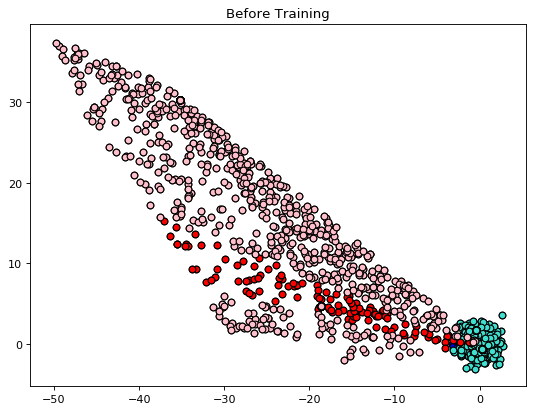

In [13]:
x = sample_normal(M)
z = sample_noise(M) 
plot_fig(generate, discriminate, 1)

### PS: 
#### Generator data are in red and pink: 
red dot means that the discriminator classifies the point as real, pink means that the discriminator classifies it as fake   

#### Real data are in blue and turquoise:
blue dot means that the discriminator classifies the point as real, turquoise means that the discriminator classifies it as fake   

In [14]:
epochs = 300
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20

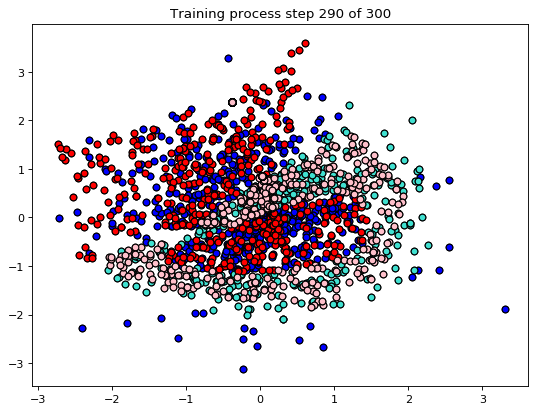

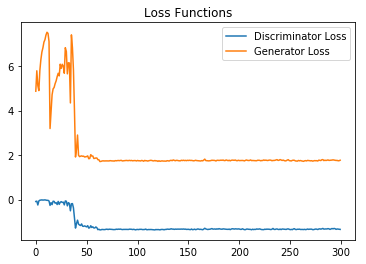

In [15]:
visualize_training = True  # set to True to monitor training progress

plt.ion()
for i in range(epochs):
    for j in range(k):
        x = sample_normal(M)
        z = sample_noise(M)  # sample m-batch from noise prior
        histd[i] = D_train(z,x)

    z = sample_noise(M)
    histg[i] = G_train(z)
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
        if visualize_training:            
            plot_fig(generate, discriminate) 

plt.ioff()

plt.clf()
plt.plot(range(epochs), histd, label='Discriminator Loss')
plt.plot(range(epochs), 1 - histg, label='Generator Loss')
plt.legend()
plt.title('Loss Functions')
plt.show()